In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from scipy.optimize import curve_fit

In [14]:
datafile = "data/SBG_data_20180322_lateral_0cm.dat"

In [104]:
logger_line = 0
header_line = 1
units_line = 2
sampling_line = 3
first_data_line = 4

def ts_convert(x):
    parts = x.split(".")
    dt = datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S")
    if len(parts) > 1:
        dt = dt.replace(microsecond=int(float("." + parts[1]) * 1e6))
    return dt

df = pd.read_csv(datafile, header=0, skiprows=[logger_line, units_line, sampling_line],
                                na_values=['NAN'],
                                converters={
                                    "TIMESTAMP": ts_convert
                                }
                                )

df["attempt"] = df["ExperimentID"] // 10000
df["distance"] = df["ExperimentID"] % 10000

expIDs = np.unique(df["ExperimentID"])

print(expIDs)

[10005 10010 10015 10020 10030 10040 10050 10060 10070 10080 10100 20005
 20010 20015 20080 20100 30005 30010 30015]


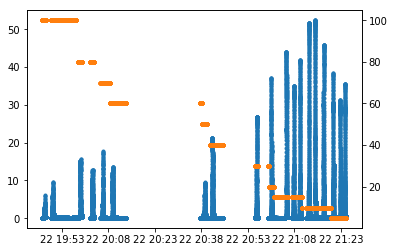

In [76]:
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df["TIMESTAMP"], df["SBG_flux"], ".")
ax2.plot(df["TIMESTAMP"], df["distance"], ".", color="C1")

plt.show()

In [152]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [40, 50, 20]

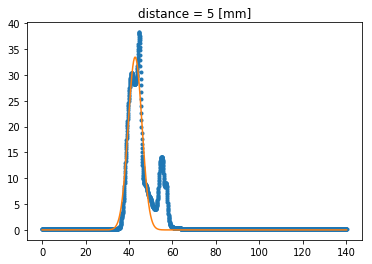

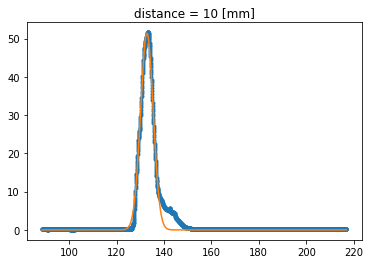

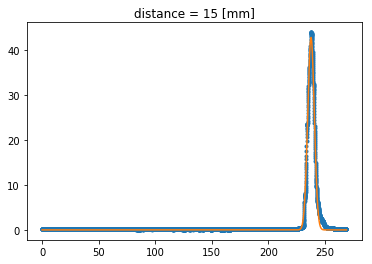

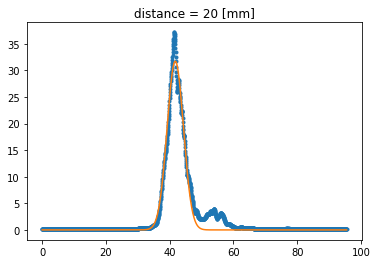

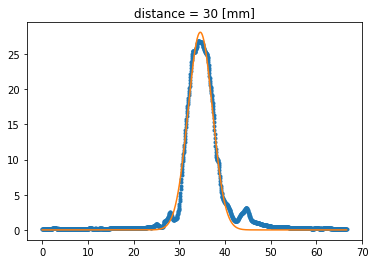

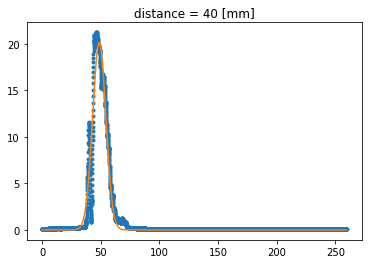

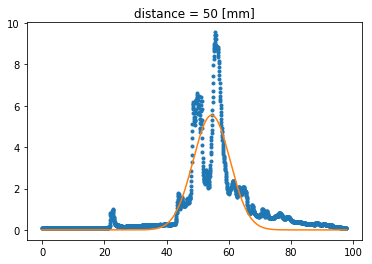

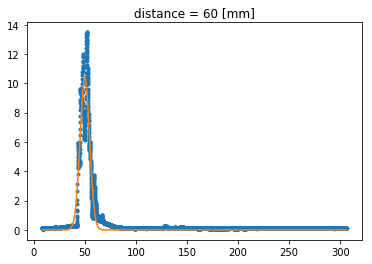

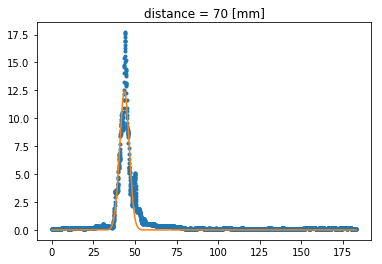

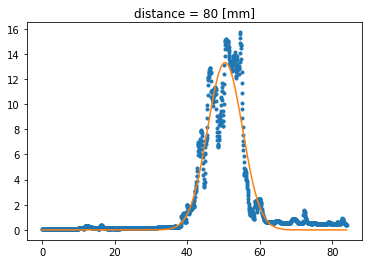

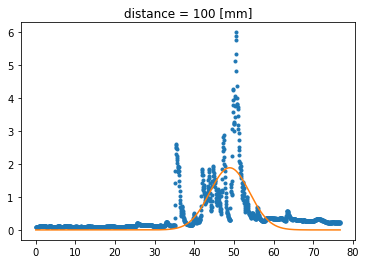

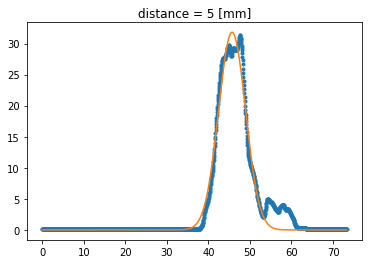

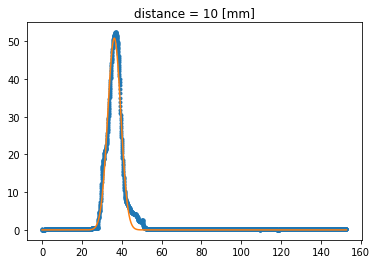

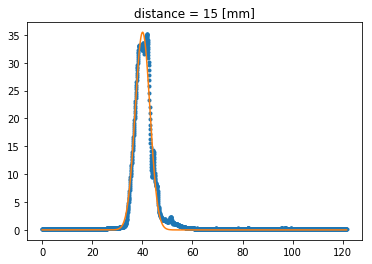

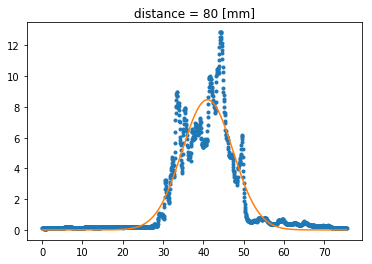

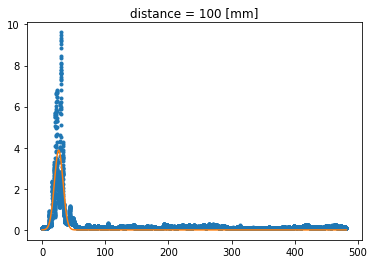

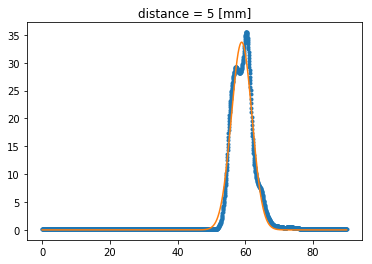

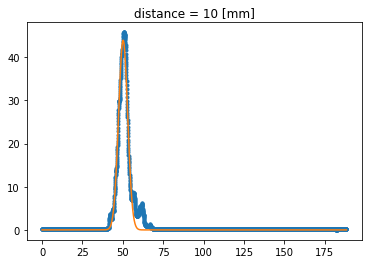

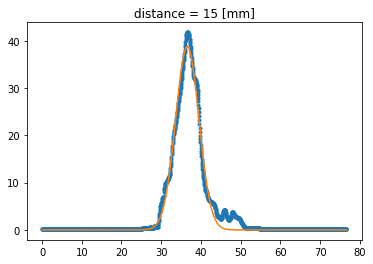

In [162]:
fit_max = []
fit_width = []
plot_max = []

for e in expIDs:
    fig = plt.figure()
    ax1 = plt.gca()
    
    df_e = df.query("ExperimentID == %d" % e)
    
    min_ts = df_e["TIMESTAMP"].min()
    time_s = (df_e["TIMESTAMP"] - min_ts).apply(lambda x: x.total_seconds())
    time_s.name = "time_s"
    
    interruption_idx = (
        [time_s.index[0]] +
        list(time_s.diff().to_frame().query("time_s > 1").index) + 
        [time_s.index[-1]]
    )
    
    longest_msmt_streak = np.argmax(np.diff(np.array(interruption_idx)))
    start_idx = interruption_idx[longest_msmt_streak]
    end_idx = interruption_idx[longest_msmt_streak + 1] - 1
    
    df_e = df_e.loc[start_idx:end_idx]
    time_s = time_s.loc[start_idx:end_idx]
    
    coeff, var_matrix = curve_fit(gauss, time_s, df_e["SBG_flux"], p0=p0)
    # Get the fitted curve
    plot_fit = gauss(time_s, *coeff)
    fit_max.append(coeff[0])
    fit_width.append(coeff[1])
    plot_max.append(np.max(df_e["SBG_flux"]))
    
    ax1.plot(time_s, df_e["SBG_flux"], ".")
    ax1.plot(time_s, plot_fit)
    ax1.set_title("distance = %d [mm]" % df_e["distance"].iloc[0])
    plt.show()
    plt.close('all')

In [163]:
fit_df = pd.DataFrame()

dists = np.array(expIDs) % 10000
atts = np.array(expIDs) // 10000

fit_df["distance"] = dists
fit_df["attempt"] = atts

fit_df["fit_max"] = fit_max
fit_df["fit_width"] = fit_width
fit_df["plot_max"] = plot_max

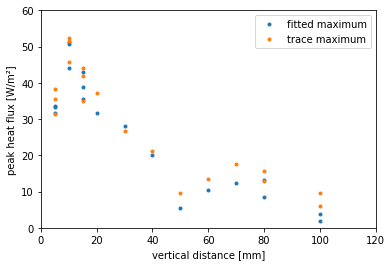

In [176]:
fig = plt.figure()
ax1 = plt.gca()

ax1.plot(fit_df["distance"], fit_df["fit_max"], ".", label="fitted maximum")
ax1.plot(fit_df["distance"], fit_df["plot_max"], ".", label="trace maximum")

ax1.set_ylim(0,60)
ax1.set_xlim(0,120)

ax1.set_ylabel("peak heat flux [W/m²]")
ax1.set_xlabel("vertical distance [mm]")
plt.legend()

plt.savefig("plots/sbg_lateral_zero_peak_flux.png", dpi=300)

plt.show()